# Convolution Neural Network with Trained Word2Vec Embeddings for Part-Of-Speech Tagging of Classical Languages - Latin

_____________________________________________________________
## Create The Dataset

In [1]:
pip install pyconll

Note: you may need to restart the kernel to use updated packages.


In [99]:
import pyconll # pyconll to read conllu files

llct1 = list(pyconll.load_from_file('la_llct-ud-dev.conllu'))
llct2 = list(pyconll.load_from_file('la_llct-ud-test.conllu'))
llct3 = list(pyconll.load_from_file('la_llct-ud-train.conllu'))
ittb1 = list(pyconll.load_from_file('la_ittb-ud-dev.conllu'))
ittb2 = list(pyconll.load_from_file('la_ittb-ud-test.conllu'))
ittb3 = list(pyconll.load_from_file('la_ittb-ud-train.conllu'))
proiel1 = list(pyconll.load_from_file('la_proiel-ud-dev.conllu'))
proiel2 = list(pyconll.load_from_file('la_proiel-ud-test.conllu'))
proiel3 = list(pyconll.load_from_file('la_proiel-ud-train.conllu'))

data = llct1 + llct2 + llct3 + ittb1 + ittb2 + ittb3 + proiel1 + proiel2 + proiel3

In [100]:
# Split data into lists of sentences and tags

X = []
Y = []

for sentence in data:
    X_sentence = []
    Y_sentence = []
    for token in sentence:
        X_sentence.append(token.form)
        Y_sentence.append(token.upos)
    X.append(X_sentence)
    Y.append(Y_sentence)

In [101]:
# Look at the data
print("First Sentence:\n")
print(X[0])
print("\nIt's Tags:\n")
print(Y[0])

First Sentence:

['+', 'In', 'Dei', 'omnipotentis', 'nomine', 'regnante', 'domno', 'nostro', 'Karolus', 'divina', 'faventem', 'clementia', 'rex', ',', 'anno', 'regni', 'eius', 'in', 'Italia', 'primo', ',', 'octavo', 'kalendas', 'decembris', ',', 'indictione', 'quarta', 'decima', '.']

It's Tags:

['PUNCT', 'ADP', 'PROPN', 'ADJ', 'NOUN', 'VERB', 'NOUN', 'DET', 'PROPN', 'ADJ', 'VERB', 'NOUN', 'NOUN', 'PUNCT', 'NOUN', 'NOUN', 'DET', 'ADP', 'PROPN', 'ADJ', 'PUNCT', 'ADJ', 'NOUN', 'ADJ', 'PUNCT', 'NOUN', 'ADJ', 'ADJ', 'PUNCT']


#### Some information about the data:

In [102]:
num_words = len(set([word.lower() for sentence in X for word in sentence]))
tags = set([word.lower() for sentence in Y for word in sentence])
num_tags = len(tags)

In [103]:
print(num_words)
print(num_tags)
print(tags)

49148
16
{'propn', 'adv', 'x', 'intj', 'cconj', 'punct', 'det', 'adj', 'pron', 'sconj', 'num', 'aux', 'noun', 'adp', 'verb', 'part'}


#### Tags: Proper Noun, Adverb, X(Other), Interjection, Coordinating Conjunction, Punctuation, Determiner, Adjective, Pronoun, Subordinating Conjunction, Numeral, Auxiliary Verb, Noun, Adposition, Verb, Particle

In [104]:
tagdict = {
    "propn": "Proper Noun",
    "adv": "Adverb",
    "x": "Other",
    "intj": "Interjection",
    "cconj": "Coordinating Conjunction",
    "punct": "Punctuation",
    "det": "Determiner",
    "adj": "Adjective",
    "pron": "Pronoun",
    "sconj": "Subordinating Conjunction",
    "num": "Numeral",
    "aux": "Auxiliary Verb",
    "noun": "Noun",
    "adp": "Adposition",
    "verb": "Verb",
    "part": "Particle"
}

_______________________________________________
## Prepare the Data 

In [105]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from gensim.models import KeyedVectors

#### Tokenize and pad each sentence and it's tags:

In [106]:
# encode X
word_tokenizer = Tokenizer(oov_token="Z")        
word_tokenizer.fit_on_texts(X)            

# use the tokenizer to encode input sentence sequence
X_encoded = word_tokenizer.texts_to_sequences(X)  

# encode Y
tag_tokenizer = Tokenizer()
tag_tokenizer.fit_on_texts(Y)

# use the tokenizer to encode input tag sequence
Y_encoded = tag_tokenizer.texts_to_sequences(Y)

In [107]:
# save the tokenizers for use in our demo
import io
import json
wtokenizer_json = word_tokenizer.to_json()
ttokenizer_json = tag_tokenizer.to_json()
with io.open('wtokenizerlatin.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(wtokenizer_json, ensure_ascii=False))
with io.open('ttokenizerlatin.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(ttokenizer_json, ensure_ascii=False))

In [108]:
# Give each sentence a length of 50 by padding with zeros or truncating.
MAX_SEQ_LENGTH = 50
X_padded = pad_sequences(X_encoded, maxlen=MAX_SEQ_LENGTH, padding='pre', truncating='post')
Y_padded = pad_sequences(Y_encoded, maxlen=MAX_SEQ_LENGTH, padding='pre', truncating='post')

#### Split the dataset into Training and Testing data:

In [109]:
X_train, X_test, Y_train, Y_test = train_test_split(X_padded, Y_padded, test_size=0.15, random_state=4)

#### Create an Embedding Matrix using Word2Vec:

In [110]:
# Word2Vec Continuous Skipgram of Latin CoNLL17 corpus
path = "model.txt"

word2vec = KeyedVectors.load_word2vec_format(path, binary=False)

# each word is represented using a 100 dimensional vector
EMBED_SIZE = 100
VOCAB_SIZE = len(word_tokenizer.word_index) + 1

# empty embedding matix
embedding_weights = np.zeros((VOCAB_SIZE, EMBED_SIZE))

# create a word to index dictionary mapping
word2id = word_tokenizer.word_index

# copy vectors from word2vec model to the words present in corpus
# fill the embedding matrix
for word, index in word2id.items():
    try:
        embedding_weights[index, :] = word2vec[word]
    except KeyError:
        pass

#### One-hot encode Y:

In [111]:
Y_train = to_categorical(Y_train)
Y_test = to_categorical(Y_test)

#### Data Shapes:

In [112]:
print("Training shapes:\n")
print(X_train.shape)
print(Y_train.shape)
print("\nTesting Shapes:\n")
print(X_test.shape)
print(Y_test.shape)

Training shapes:

(46249, 50)
(46249, 50, 17)

Testing Shapes:

(8162, 50)
(8162, 50, 17)


________________________________________________
## Build the Model

In [113]:
from keras.models import Model
from keras.models import Sequential
from keras import layers
from tensorflow.keras import backend as K

#### Function to ignore the accuracy of paddings:
##### From: https://nlpforhackers.io/lstm-pos-tagger-keras/ 

In [114]:
def accuracy_masked(y_true, y_pred):
    y_true_class = K.argmax(y_true, axis=-1)
    y_pred_class = K.argmax(y_pred, axis=-1)

    ignore_mask = K.cast(K.not_equal(y_true_class, 0), 'int32')
    matches = K.cast(K.equal(y_true_class, y_pred_class), 'int32') * ignore_mask
    accuracy = K.sum(matches) / K.maximum(K.sum(ignore_mask), 1)
    return accuracy

#### Sequential Convolution Network:

In [123]:
model = Sequential()
model.add(layers.Embedding(input_dim   = VOCAB_SIZE,
                         output_dim    = EMBED_SIZE,         
                         input_length  = MAX_SEQ_LENGTH,          
                         weights       = [embedding_weights],     
                         trainable     = True                   
))
model.add(layers.Conv1D(128, kernel_size=2, padding='same', activation='relu'))
model.add(layers.MaxPooling1D(pool_size=1, strides=1, padding='same'))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(17, activation='softmax'))
model.compile(loss=keras.losses.CategoricalCrossentropy(),
 optimizer=keras.optimizers.Adam(),
 metrics=[keras.metrics.CategoricalAccuracy(), accuracy_masked])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 50, 100)           4915000   
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 50, 128)           25728     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 50, 128)           0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 50, 128)           0         
_________________________________________________________________
dense_16 (Dense)             (None, 50, 128)           16512     
_________________________________________________________________
dropout_17 (Dropout)         (None, 50, 128)           0         
_________________________________________________________________
dense_17 (Dense)             (None, 50, 128)          

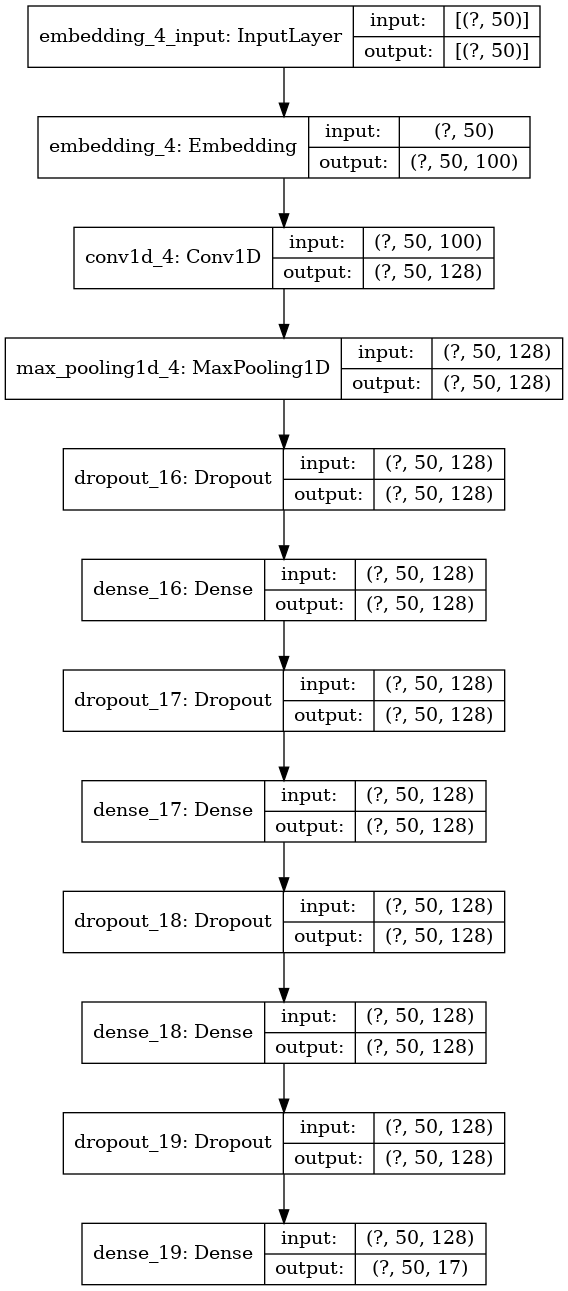

In [124]:
keras.utils.plot_model(model, to_file='cnnmodel.png', show_shapes=True)

________________________________________________
## Train the Model

In [125]:
history = model.fit(X_train, Y_train,
                    epochs=24,
                    validation_split=0.2,
                    batch_size=128)

Epoch 1/24
290/290 [==============================] - 29s 99ms/step - loss: 0.5298 - categorical_accuracy: 0.8587 - accuracy_masked: 0.5890 - val_loss: 0.1093 - val_categorical_accuracy: 0.9646 - val_accuracy_masked: 0.8844
Epoch 2/24
290/290 [==============================] - 28s 98ms/step - loss: 0.1222 - categorical_accuracy: 0.9626 - accuracy_masked: 0.8800 - val_loss: 0.0775 - val_categorical_accuracy: 0.9754 - val_accuracy_masked: 0.9196
Epoch 3/24
290/290 [==============================] - 28s 96ms/step - loss: 0.0884 - categorical_accuracy: 0.9739 - accuracy_masked: 0.9164 - val_loss: 0.0711 - val_categorical_accuracy: 0.9776 - val_accuracy_masked: 0.9266
Epoch 4/24
290/290 [==============================] - 30s 102ms/step - loss: 0.0752 - categorical_accuracy: 0.9779 - accuracy_masked: 0.9293 - val_loss: 0.0691 - val_categorical_accuracy: 0.9784 - val_accuracy_masked: 0.9291
Epoch 5/24
290/290 [==============================] - 29s 98ms/step - loss: 0.0674 - categorical_accura

In [126]:
tf.keras.models.save_model(
    model, "latinModel", overwrite=True, include_optimizer=True, save_format='tf',
    signatures=None, options=None)

INFO:tensorflow:Assets written to: latinModel/assets


___________________________________________________
## Results

In [127]:
import matplotlib.pyplot as plt
%matplotlib inline

In [128]:
# Evaluate the final performance of the network
score = model.evaluate(X_test,Y_test,verbose=1)
print("Loss:",score[0])
print("Accuracy:",score[1])
print("Masked Accuracy: ", score[2])

256/256 [==============================] - 2s 8ms/step - loss: 0.0741 - categorical_accuracy: 0.9801 - accuracy_masked: 0.9362
Loss: 0.07413626462221146
Accuracy: 0.9800514578819275
Masked Accuracy:  0.9361894130706787


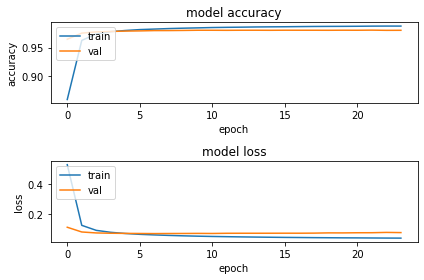

In [129]:
plt.figure(1) 

# summarize history for accuracy

plt.subplot(211)
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

# summarize history for loss

plt.subplot(212)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.tight_layout()
plt.show() 

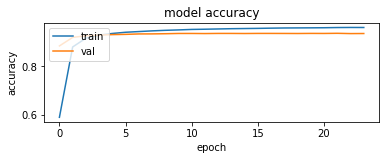

In [130]:
plt.figure(1) 

# summarize history for masked accuracy

plt.subplot(211)
plt.plot(history.history['accuracy_masked'])
plt.plot(history.history['val_accuracy_masked'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

___________________________________
## Demo

In [131]:
from nltk.tokenize import word_tokenize

def output_prediction(text):
    # Pre-process data like we did for training.
    text = [word_tokenize(text)]
    text_encoded = word_tokenizer.texts_to_sequences(text) 
    text_padded = pad_sequences(text_encoded, maxlen=MAX_SEQ_LENGTH, padding='pre', truncating='post')

    # Make a prediction
    ynew = np.argmax(model.predict(text_padded), axis=-1)
    prediction = ynew[0]
    
    # Trim leading zeros
    prediction = np.trim_zeros(prediction)
        
    # Decode prediction
    decoded = tag_tokenizer.sequences_to_texts([prediction])
    decoded = word_tokenize(decoded[0])
    decoded = [tagdict[tag] for tag in decoded]
    
    # show the inputs and predicted outputs
    print("      Sentence= %s\nPredicted Tags= %s" % (text, decoded))
    
text = "Forsan et haec olim meminisse iuvabit"
output_prediction(text)

      Sentence= [['Forsan', 'et', 'haec', 'olim', 'meminisse', 'iuvabit']]
Predicted Tags= ['Adverb', 'Coordinating Conjunction', 'Adjective', 'Adverb', 'Verb', 'Other']


__________________________________________________________________
Data Pre-Processing Inspired By: https://towardsdatascience.com/pos-tagging-using-rnn-7f08a522f849,
https://github.com/pyconll/pyconll,
https://universaldependencies.org/format.html
Model Inspired By: https://medium.com/saarthi-ai/sentence-classification-using-convolutional-neural-networks-ddad72c7048c
Masked Accuracy Class Inspired By: https://nlpforhackers.io/lstm-pos-tagger-keras/
Treebank (Latin): https://universaldependencies.org/
Word Embeddings: http://vectors.nlpl.eu/repository/#